In [ ]:
!mkdir ~/.kaggle/
!echo '{"username":"USER_NAME","key":"TOKEN"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c cassava-disease

  0% 0.00/645k [00:00<?, ?B/s]
100% 645k/645k [00:00<00:00, 44.2MB/s]
  0% 0.00/83.8k [00:00<?, ?B/s]
100% 83.8k/83.8k [00:00<00:00, 86.2MB/s]
100% 775M/777M [00:21<00:00, 16.9MB/s]
100% 777M/777M [00:21<00:00, 38.5MB/s]
 98% 505M/515M [00:32<00:00, 15.1MB/s]
100% 515M/515M [00:32<00:00, 16.5MB/s]
 99% 1.03G/1.04G [00:12<00:00, 104MB/s]
100% 1.04G/1.04G [00:12<00:00, 91.5MB/s]


In [ ]:
%%capture
!unzip -n train.zip
!unzip -n test.zip
!unzip -n extraimages.zip

In [ ]:
# install library
!pip install --upgrade wandb
!wandb login TOKEN

     |████████████████████████████████| 2.0MB 15.8MB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
     |████████████████████████████████| 163kB 54.6MB/s 
     |████████████████████████████████| 133kB 57.3MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=2346f2b47dcd3924e9c4a67879fe54bb1833d48d344b84a59f843065775c5178
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=0961e79d35c34952571c5088eef70ce0bc1ca71da8e8a86bc891957bafa3c9a0
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, SubsetRandomSampler
import matplotlib.pyplot as plt
import time

from sklearn.metrics import classification_report

# optional
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.1+cu101
Torchvision Version:  0.8.2+cu101


# Load Data

In [ ]:
train_transform = transforms.Compose([
    #transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(448, scale=(0.5, 1.2)),
    transforms.RandomHorizontalFlip(), #----
    transforms.RandomVerticalFlip(),
    #transforms.ColorJitter(brightness=.05, contrast=.05, hue=0, saturation=.05),
    transforms.ToTensor(), 
    transforms.Lambda(lambda x : x + torch.randn_like(x)/40), #add noise
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(448),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder('train', transform=train_transform) # <---
valid_dataset = datasets.ImageFolder('train', transform=test_transform)

# Data understand

class_names : ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']
dataset size: 5656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


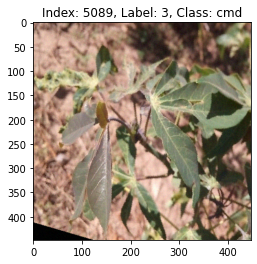

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


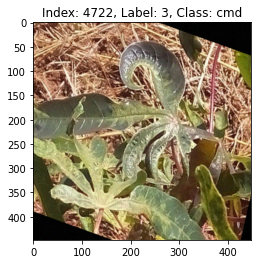

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


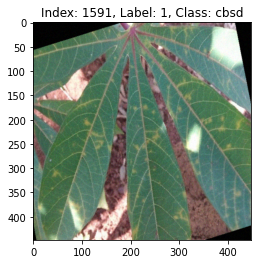

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


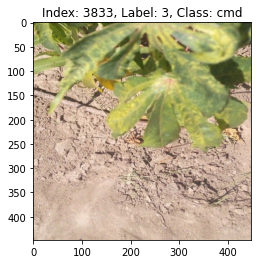

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


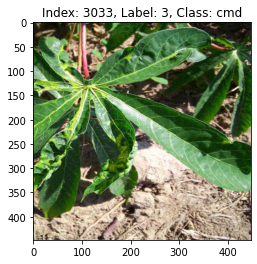

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


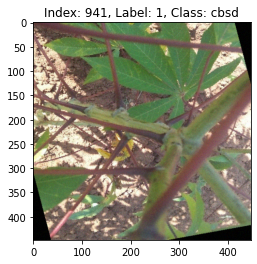

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


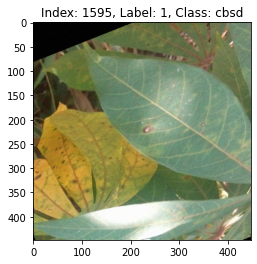

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


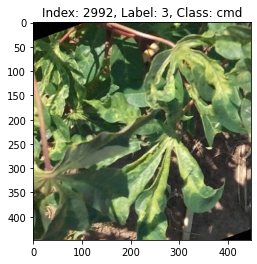

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


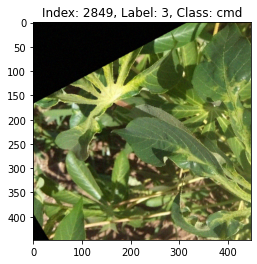

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


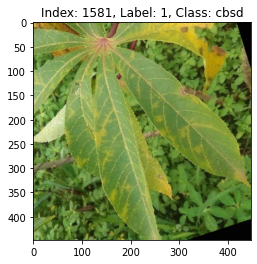

In [ ]:
labels_total = len(dataset.targets)
class_names = dataset.classes

print(f'class_names : {class_names}')
print(f'dataset size: {len(dataset)}')

def img_tensor_show(img):
    img = img.permute(1,2,0)
    img = img.numpy()*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    plt.imshow(img)
    plt.show()

for i in np.random.randint(0, labels_total, 10): #100,566,2600,5000,5400:
    img, label = dataset[i]
    plt.title(f'Index: {i}, Label: {label}, Class: {class_names[label]}')
    img_tensor_show(img)

In [ ]:
labels = dataset.targets # list of all the labels

In [ ]:
# plt.title('data distribution')
# bars = plt.bar(class_names, labels_count)
# for bar in bars:enumerate(distribution):
#     plt.text(bar.get_x(), bar.get_height() + 0.01, str(v))
# plt.show()

class distibustion: [ 8.23903819 25.51272984 13.6669024  46.99434229  5.58698727]
rebalance factor: [5.70386266 1.84199584 3.4385511  1.         8.41139241]


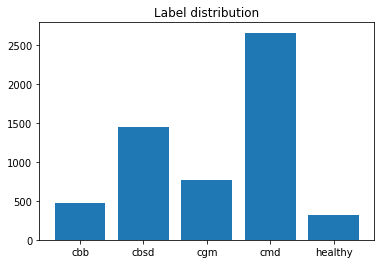

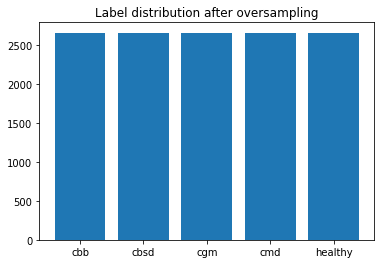

class,	 count,	 distribution
cbb,	 466,	 8%
cbsd,	 1443,	 25%
cgm,	 773,	 13%
cmd,	 2658,	 46%
healthy,	 316,	 5%
Total images in dataset : 5656


In [ ]:
_, labels_count = np.unique(dataset.targets, return_counts=True)

distribution = 100*labels_count/labels_total
print('class distibustion:',distribution)
print('rebalance factor:', distribution.max()/distribution)
labels_count_oversampling = labels_count*distribution.max()/distribution
# labels_count_undersampling = 100*labels_count/(100-distribution)

plt.title('Label distribution')
plt.bar(class_names, labels_count)
plt.show()

plt.title('Label distribution after oversampling')
plt.bar(class_names, labels_count_oversampling)
plt.show()

# plt.title('Label distribution after undersampling')
# plt.bar(class_names, labels_count_undersampling)
# plt.show()

# Dispplay the values
print(f'class,\t count,\t distribution')
for class_name, count in zip(class_names, labels_count):
    print(f'{class_name},\t {count},\t {int(100*count/labels_total)}%')
print('Total images in dataset :', labels_total)

In [ ]:
dataset_size = len(dataset)
dist = 100*labels_count / dataset_size

for class_name, count, distrib in zip(class_names, labels_count, dist):
    print(f'{class_name}\t: {distrib:.1f}% - {count}/{dataset_size} images')
#print('Total images :', len(dataset))

cbb	: 8.2% - 466/5656 images
cbsd	: 25.5% - 1443/5656 images
cgm	: 13.7% - 773/5656 images
cmd	: 47.0% - 2658/5656 images
healthy	: 5.6% - 316/5656 images


In [ ]:
#  466, 0.8
#  1443, 0.25
#  773, 0.13
#  2658, 0.46
#  316, 0.5
# Total images in dataset : 5656

# _, labels_count = np.unique(dataset.targets, return_counts=True)

# distribution = 100*labels_count/labels_total
# plt.bar(class_names, distribution)
# plt.show()

# for class_name, count in zip(class_names, labels_count):
#     print(f'{class_name} {count} {int(100*count/labels_total)}%')
# print('Total images in dataset :', labels_total)

# Split data

In [ ]:
from sklearn.model_selection import train_test_split

#split train and test
train_idx, valid_idx = train_test_split(
    np.arange(dataset_size),
    test_size=0.2,
    shuffle=True,
    random_state=0,
    stratify=dataset.targets) # why stratify?

# train_idx, valid_idx = train_test_split(
#     train_idx,
#     test_size=0.2, # .7, .15, .15
#     shuffle=True,
#     stratify=labels[train_idx])

In [ ]:
batch_size = 14

labels = np.array(dataset.targets)

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
#test_sampler  = SubsetRandomSampler(test_idx)

def class_imbalance_sampler(labels, downsample=False):
    class_count = np.bincount(labels[train_idx]) # output -> [10, 100, 5] 
    print('class_count',class_count)

    # resample weigth, convert it from [0.1, 1, 0.05] -> to -> [10, 1, 100]
    if downsample:
        sample_class = 2
        class_weighting = class_count[sample_class]/class_count
    else:
        class_weighting = class_count.max()/class_count
    print('class_weighting',class_weighting)

    #assign weigth sample to image in the dataset according to the label
    sample_weights = class_weighting[labels]

    if downsample:
        rand_selection = np.random.rand(len(labels))
        sample_weights[ sample_weights < rand_selection] = 0
        sample_weights[ (sample_weights < 1.0) * (sample_weights > 0) ] = 1.0

    #remove image in the valid set by give them weigth of 0
    sample_weights[valid_idx] = 0 # disable non indexed

    num_samples = int(sum(sample_weights > 0))
    print('num_samples:',num_samples)

    sampler = WeightedRandomSampler(sample_weights, num_samples, replacement=True)
    return sampler

# labels as sampler base
#train_sampler = class_imbalance_sampler(labels, downsample=False)

train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=4, sampler=train_sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=4, sampler=valid_sampler)

## Define Focal Loss

In [ ]:
# Focal Loss Function for imbalance dataset
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=False):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
      nn.CrossEntropyLoss()
      BCE_loss = nn.CrossEntropyLoss()(inputs, targets)#, reduce=False)
      pt = torch.exp(-BCE_loss)
      F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
      if self.reduce:
        return torch.mean(F_loss)
      else:
        return F_loss

# Model

In [ ]:
#model = torchvision.models.densenet201(pretrained=True)
#model = torchvision.models.resnext101_32x8d(pretrained=True)
#model = torchvision.models.resnext50_32x4d(pretrained=True)
#model = torchvision.models.wide_resnet101_2(pretrained=True)
model = torchvision.models.resnet18(pretrained=True)
#model = torchvision.models.vgg11_bn(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# for param in model.parameters():
#     param.requires_grad = False

############ ResNet Familly
# for param in model.conv1.parameters():
#     param.requires_grad = False
# for param in model.layer1.parameters():
#     param.requires_grad = False

# for name, param in model.named_parameters():
#     if "bn" not in name:
#         param.requires_grad = False

# for param in model.layer4.parameters():
#     param.requires_grad = True
# for param in model.layer3.parameters():
#     param.requires_grad = True

# def random_freeze(model):
#     for param in model.parameters():
#         param.requires_grad = np.random.rand() > 0.5
#     for param in model.conv1.parameters():
#         param.requires_grad = np.random.rand() > 1.0
#     for param in model.layer1.parameters():
#         param.requires_grad = np.random.rand() > 1.0
#     for param in model.fc.parameters():
#         param.requires_grad = np.random.rand() > 0.2

############## DenseNet
# for name, param in model.named_parameters():
#     if "norm" not in name:
#         param.requires_grad = False

# for param in model.features.denseblock4.parameters():
#     param.requires_grad = True
# for param in model.features.transition3.parameters():
#     param.requires_grad = True
# for param in model.features.denseblock3.parameters():
#     param.requires_grad = True
# for param in model.features.transition2.parameters():
#     param.requires_grad = True
# for param in model.features.denseblock2.parameters():
#     param.requires_grad = True

In [ ]:
model.fc = nn.Linear(in_features=2048, out_features=5) #resenet
# model.classifier = nn.Linear(in_features=1920, out_features=5) #densenet, vgg

In [ ]:
# # Load model
model_path = '/content/drive/My Drive/lectures/cassava-conv/models'
last_model_name  = 'last-model-bizzare-carole.nnm'
best_model = 'resnext50_32x4d-5epoch-oneCyclic.nnm'
# model.load_state_dict(torch.load(model_path+'/'+model_name))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p '{model_path}'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hyper parameter

In [ ]:
device = 'cuda'

In [ ]:
model = model.to(device)

In [ ]:
hist = {
    'train_loss':[],
    'train_acc':[],
    'val_loss':[],
    'val_acc':[],
}

In [ ]:
# optim.SGD([{'params': [param for name, param in model.named_parameters() if 'fc2' not in name]}, {'params': model.fc2.parameters(), 'lr': 5e-3}], lr=1e-2)

#model.load_state_dict(torch.load(model_path+'/densenet201-fc-80acc.nnm'))

In [ ]:
def get_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
epochs = 20
accumulation_step = 4
learning_rate = 1e-3 * batch_size * accumulation_step #0.01 #1e-8
learning_rate

0.056

In [ ]:
#criterion = nn.CrossEntropyLoss()
criterion = FocalLoss(gamma=3)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = torch.optim.SGD([
#     { 'params': model.layer4.parameters(), 'lr': found_lr /3},
#     { 'params': model.layer3.parameters(), 'lr': found_lr /9},
# ], lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
#                 max_lr=learning_rate, steps_per_epoch=len(train_loader)//accumulation_step, epochs=epochs)

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, patience=5, factor=0.1, min_lr=1e-7, verbose=True)

# Train

In [ ]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.056
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [ ]:
import wandb

#wandb.init(entity="carolight_godglory", project="kaggle_cassava_desease")

#log to wandb
wandb.config.epochs        = epochs
#wandb.config.learning_rate = learning_rate
wandb.config.batch_size  = batch_size
wandb.config.model       = model.__class__.__name__ + '_dense201'
wandb.config.optimizer   = optimizer.__class__.__name__
#wandb.config.optimizer_param = str(optimizer)
wandb.config.criterion   = criterion.__class__.__name__
wandb.config.accumulation_step = accumulation_step
wandb.config.note        = 'carole bizzarerie' 

try: wandb.watch(model)
except: pass

for epoch in range(epochs):
    print(f'Epoch {epoch+1}')
    start_time = time.time()

    ################################# Training
    number_correct = 0
    sum_loss = 0
    debug_total = 0
    debug_rebalance = np.zeros(5)
    
    model.train()
    optimizer.zero_grad()
    for i, (datas, targets) in enumerate(train_loader):
        debug_total += len(datas)
        # for target in targets:
        #     debug_rebalance[target] += 1

        datas = datas.to(device)
        targets = targets.to(device)

        #predict
        outputs = model(datas)
        #print(outputs.shape)
        
        #compute loss
        loss = criterion(outputs, targets)
        
        #compute gradient
        loss.backward()
        if (i + 1) % accumulation_step == 0:
            #update model
            optimizer.step()
            optimizer.zero_grad()

        #scheduler.step()

        #compute metrics
        sum_loss += loss.item()
        _, max_indices = torch.max(outputs,1)
        number_correct += (max_indices == targets).sum().item()

        #random_freeze(model)
        if i>10 and i%(400//batch_size) == 0:
            print(f'{100*number_correct/i/batch_size:.1f}, ', end='')

    #print metrics for train
    loss = sum_loss / len(train_loader)
    accuracy = 1.0 * number_correct / len(train_idx) # debug_total

    hist['train_loss'].append(loss)
    hist['train_acc'].append(accuracy)
    print('')
    print(f'Train : Loss {loss:.5f}, Accuracy {100*accuracy:.2f}, debug:{debug_total} vs {len(train_idx)}')
    wandb.log({'train_accuracy': accuracy, 'train_loss': loss, 'epoch':epoch}, commit=False)

    ############################# Validation
    number_correct = 0
    sum_loss = 0
    debug_total = 0

    valid_outputs = []
    valid_labels  = []        

    model.eval()
    with torch.no_grad():
        for i, (datas, targets) in enumerate(valid_loader):
            debug_total += len(datas)
            datas = datas.to(device)
            targets = targets.to(device)
            #predict
            outputs = model(datas)
            
            #compute loss
            loss = criterion(outputs, targets)

            #compute metrics
            sum_loss += loss.item()
            _, max_indices = torch.max(outputs,1)
            number_correct += (max_indices == targets).sum().item()

            #update pred history
            valid_outputs.append(outputs.cpu())
            valid_labels.append(targets.cpu())

    valid_outputs = torch.cat(valid_outputs)
    valid_labels  = torch.cat(valid_labels)

    #print metrics for valid
    loss = sum_loss / len(valid_loader)
    accuracy = 1.0 * number_correct / len(valid_idx)

    #scheduler.step(loss)

    hist['val_loss'].append(loss)
    hist['val_acc'].append(accuracy)
    print(f'Valid : Loss {loss:.5f}, Accuracy {100*accuracy:.2f}, debug:{debug_total} vs {len(valid_idx)}')
    wandb.log({'test_accuracy': accuracy, 'test_loss': loss}, commit=False)
    
    current_lr = get_learning_rate(optimizer)
    eleapse = time.time() - start_time
    print(f' --- epoch duration : {int(eleapse)}sec ETA: {eleapse*(epochs-epoch-1)/60:.1f}min lr:{current_lr}\n')
    wandb.log({'time in min': eleapse/60.0, 'learning_rate':current_lr}, commit=False)

    #if the accury is better save the model
    if max(hist['val_acc']) == accuracy:
        torch.save(model.state_dict(), f'{model_path}-{accuracy:.4f}acc')
        torch.save(model.state_dict(), os.path.join(wandb.run.dir, f'model-{accuracy:.4f}.pt'))
        print(f'Save model with accuracy {accuracy:.2f}')
    
    report = classification_report(y_true=valid_labels, y_pred=valid_outputs.max(1)[1], target_names=class_names, output_dict=True)
    report_printable = classification_report(y_true=valid_labels, y_pred=valid_outputs.max(1)[1], target_names=class_names)
    print(report_printable)
    wandb.log(report, commit=True)
    !uptime -p
    

    # plt.figure(figsize=(5,5))
    # plot_confusion_matrix(confusion_matrix, class_names, normalize=True)
    # plt.show()
    
    # print(debug_rebalance)
    # plt.bar(class_names, debug_rebalance)
    # plt.show()

Epoch 1
88.3, 70.5, 71.1, 71.9, 73.0, 75.5, 77.3, 78.3, 79.2, 80.1, 80.7, 
Train : Loss 5.24934, Accuracy 80.86, debug:4524 vs 4524
Valid : Loss 5.36176, Accuracy 81.27, debug:1132 vs 1132
 --- epoch duration : 111sec ETA: 35.4min lr:0.056

              precision    recall  f1-score   support

         cbb       0.50      0.67      0.57        93
        cbsd       0.73      0.88      0.79       289
         cgm       0.83      0.87      0.85       155
         cmd       0.96      0.80      0.87       532
     healthy       0.84      0.65      0.73        63

    accuracy                           0.81      1132
   macro avg       0.77      0.77      0.77      1132
weighted avg       0.84      0.81      0.82      1132

up 9 hours, 8 minutes
Epoch 2
85.7, 86.2, 86.4, 86.6, 86.8, 86.5, 86.9, 86.7, 87.2, 87.2, 86.6, 
Train : Loss 3.11864, Accuracy 86.05, debug:4524 vs 4524
Valid : Loss 8.04932, Accuracy 74.03, debug:1132 vs 1132
 --- epoch duration : 113sec ETA: 34.1min lr:0.056

       

# Visualization

In [ ]:
# torch.save(model.state_dict(), model_path+'/resnext101_32x8d-10epoch+oneCyclic+layer4.nnm')
# torch.save(torch.Tensor(train_idx), model_path+'/../train_idx-0.2.torch')
# torch.save(torch.Tensor(valid_idx), model_path+'/../valid_idx-0.2.torch')

# model.load_state_dict(torch.load(PATH))
# model.eval()

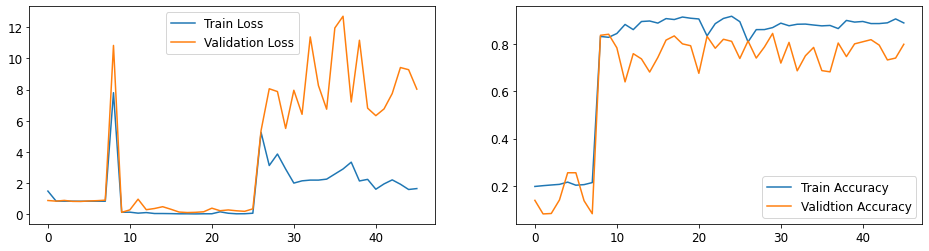

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(hist['train_loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist['train_acc'], label='Train Accuracy')
plt.plot(hist['val_acc'], label='Validtion Accuracy')
plt.legend()

plt.show()

In [ ]:
# print('Load:',best_model)
# model.load_state_dict(torch.load(model_path+'/'+best_model))
# model.load_state_dict(torch.load(model_path+'/'+last_model_name))

In [ ]:
#Confusion Matrix
confusion_matrix = np.zeros((5,5))

model.eval()
with torch.no_grad():
  for datas, targets in valid_loader:
    datas = datas.to(device)
    targets = targets.to(device)
    #predict
    outputs = model(datas)

    #update confusion
    _, predictions = torch.max(outputs,1)
    for target,pred in zip(targets,predictions):
      confusion_matrix[target,pred] += 1

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.rcParams.update({'font.size': 18})

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '{:.2f}' if normalize else '{:.0f}'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt.format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.rcParams.update({'font.size': 12})

In [ ]:
valid_outputs = []
valid_labels  = []

model.eval()
with torch.no_grad():
    for datas, targets in valid_loader:
        datas = datas.to(device)
        #predict
        outputs = model(datas)
        #store
        valid_outputs.append(outputs.cpu())
        valid_labels.append(targets)

valid_outputs = torch.cat(valid_outputs)
valid_labels  = torch.cat(valid_labels)

In [ ]:
valid_outputs.shape, valid_labels.shape

(torch.Size([1132, 1000]), torch.Size([1132]))

In [ ]:
valid_outputs[:2]

tensor([[ 9.3018, 12.8198,  9.8886,  ...,  0.3688,  0.7338,  0.1581],
        [10.0638, 12.1361,  9.7759,  ..., -1.1193,  1.6018,  2.0145]])

(array([[  0., 480., 513., ...,   0.,   0.,   0.],
        [ 15., 474., 489., ...,   1.,   0.,   0.],
        [ 32., 464., 462., ...,   0.,   0.,   0.],
        ...,
        [  8., 486., 485., ...,   1.,   0.,   0.],
        [  3., 495., 489., ...,   0.,   0.,   0.],
        [  4., 490., 495., ...,   0.,   0.,   0.]]),
 array([-6.398213 , -3.2349606, -0.0717083,  3.091544 ,  6.2547965,
         9.418049 , 12.581301 , 15.744554 , 18.907806 , 22.071058 ,
        25.23431  ], dtype=float32),
 <a list of 1132 Lists of Patches objects>)

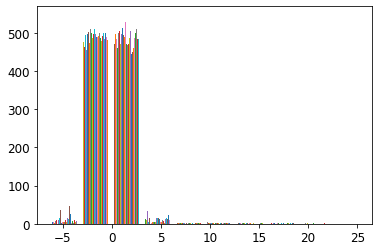

In [ ]:
plt.hist(valid_outputs)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=valid_labels, y_pred=valid_outputs.max(1)[1], target_names=class_names))

              precision    recall  f1-score   support

         cbb       0.08      1.00      0.15        93
        cbsd       0.00      0.00      0.00       289
         cgm       0.00      0.00      0.00       155
         cmd       0.00      0.00      0.00       532
     healthy       0.00      0.00      0.00        63

    accuracy                           0.08      1132
   macro avg       0.02      0.20      0.03      1132
weighted avg       0.01      0.08      0.01      1132



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Confusion Matrix
confidence = 0.9998
confusion_matrix_secure = np.zeros((5,5))
confusion_matrix = np.zeros((5,5))

for i, (label, outputs) in enumerate(zip(valid_labels,valid_outputs)):
    #print('label:',label, ' - outputs:',outputs)
    print(outputs)
    probs = nn.functional.softmax(outputs[:5],0)

    max_prob = torch.max(probs)
    pred     = torch.argmax(probs)

    confusion_matrix[label,pred] += 1
    
    #check confidence
    if max_prob > confidence:
        confusion_matrix_secure[label,pred] += 1

    if i > 10:
        break

tensor([ 0.2243, -0.0600,  0.0695, -0.1185, -0.1086])
tensor([ 0.2243, -0.0600,  0.0695, -0.1185, -0.1086])
tensor([ 0.2243, -0.0600,  0.0695, -0.1185, -0.1086])
tensor([ 0.2243, -0.0600,  0.0695, -0.1185, -0.1086])
tensor([ 0.2243, -0.0600,  0.0695, -0.1185, -0.1086])
tensor([ 0.2243, -0.0600,  0.0695, -0.1185, -0.1086])
tensor([ 0.2243, -0.0600,  0.0695, -0.1185, -0.1086])
tensor([ 0.2243, -0.0600,  0.0695, -0.1185, -0.1086])
tensor([ 0.2243, -0.0600,  0.0695, -0.1185, -0.1086])
tensor([ 0.2243, -0.0600,  0.0695, -0.1185, -0.1086])
tensor([ 0.2243, -0.0600,  0.0695, -0.1185, -0.1086])
tensor([ 0.2243, -0.0600,  0.0695, -0.1185, -0.1086])


Confusion matrix, without normalization
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


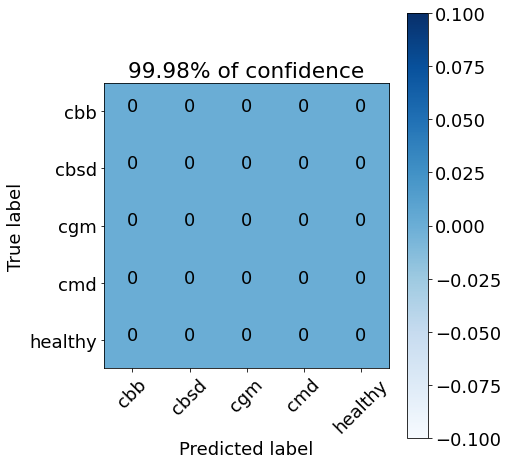

In [ ]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(confusion_matrix_secure, class_names, normalize=False, title=f'{100*confidence:.2f}% of confidence')
plt.show()

Confusion matrix, without normalization
[[ 93.   0.   0.   0.   0.]
 [289.   0.   0.   0.   0.]
 [155.   0.   0.   0.   0.]
 [532.   0.   0.   0.   0.]
 [ 63.   0.   0.   0.   0.]]


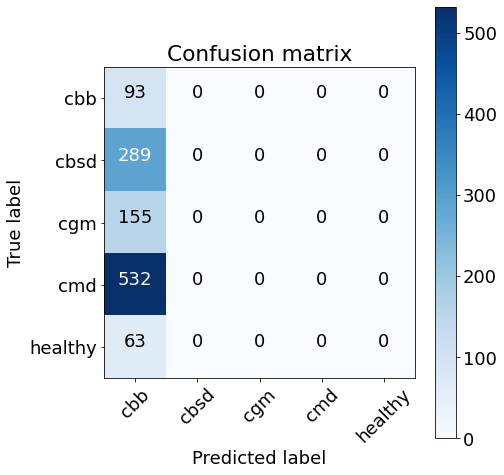

In [ ]:
#import seaborn as sn
plt.figure(figsize=(7,7))
plot_confusion_matrix(confusion_matrix, class_names, normalize=False)
plt.show()

Confusion matrix, without normalization
[[ 62.  23.   3.   4.   1.]
 [ 19. 253.   2.   9.   6.]
 [  2.   4. 129.  16.   4.]
 [  5.  10.  13. 503.   1.]
 [  0.   5.   1.   6.  51.]]


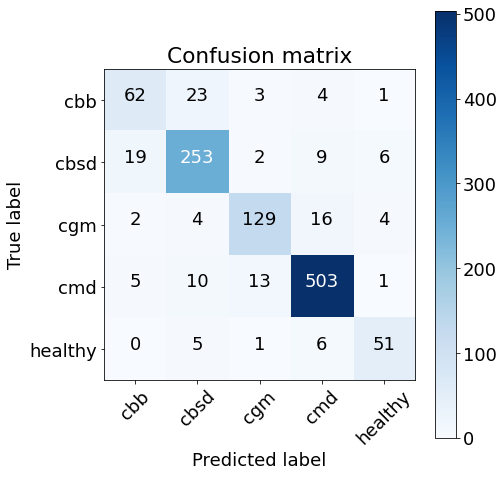

#Labels generation

In [ ]:
!mkdir extraimages_dataset
!mv extraimages extraimages_dataset

In [ ]:
extraimages_dataset = datasets.ImageFolder('extraimages_dataset', transform=test_transform)
extraimages_loader = DataLoader(extraimages_dataset, batch_size=batch_size)

In [ ]:
#makes predictions
extraimages_pred = []

with torch.no_grad():
    for datas, _ in extraimages_loader:
        datas = datas.to(device)
        #predict
        outputs = model(datas)
        #save predict
        extraimages_pred.append(outputs.cpu())
        
extraimages_pred = torch.cat(extraimages_pred)

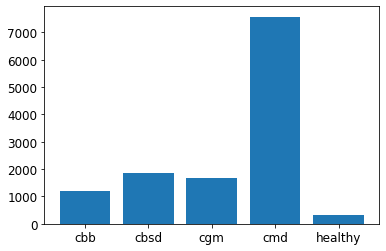

[1184 1856 1665 7573  317]


In [ ]:
_, dist = np.unique(extraimages_pred.max(1)[1], return_counts=True)
plt.bar(class_names, dist)
plt.show()
print(dist)

In [ ]:
probs = nn.functional.softmax(extraimages_pred, 1)
pred_probs, pred = torch.max(probs, 1)

In [ ]:
confidence

0.99

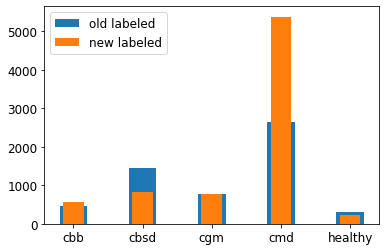

old labeled [ 466 1443  773 2658  316]
new labeled [ 567  837  772 5384  226]


In [ ]:
_, dist = np.unique(pred[pred_probs > confidence], return_counts=True)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(class_names, labels_count, width=0.4, label='old labeled')
ax.bar(class_names, dist, width=0.3, label='new labeled')
plt.legend()
plt.show()
print('old labeled', labels_count)
print('new labeled',  dist)

## classifiy unlabeled

In [ ]:
output_dir = f'./classified-{confidence}'

!mkdir {output_dir}
for class_name in class_names:
    !mkdir '{output_dir}/{class_name}'

for i, (img_path,_) in enumerate(extraimages_dataset.imgs):
    filename = img_path[11:]
    if pred_probs[i] > confidence:
        !copy {img_path} {output_dir}/{class_names[pred[i]]}/{filename}

----
# Submission

In [ ]:
test_dataset = datasets.ImageFolder('test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
#makes predictions
predictions = []

with torch.no_grad():
    for datas, _ in test_loader:
        datas = datas.to(device)
        #predict
        outputs = model(datas)
        _, max_indices = torch.max(outputs,1)
        #save predict
        predictions.append(max_indices.cpu())
        
predictions = torch.cat(predictions)

In [ ]:
predictions[:20]

tensor([1, 1, 3, 2, 1, 2, 3, 3, 3, 2, 0, 3, 4, 3, 3, 4, 3, 1, 3, 3])

(array([ 284.,    0.,  937.,    0.,    0.,  539.,    0., 1758.,    0.,
         256.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

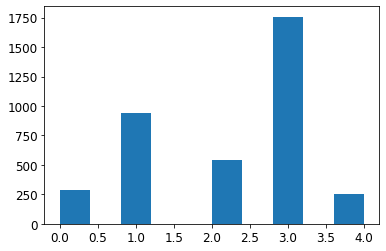

In [ ]:
plt.hist(predictions)

In [ ]:
predictions[:20]

tensor([1, 1, 3, 2, 1, 2, 3, 3, 3, 2, 0, 3, 4, 3, 3, 4, 3, 1, 3, 3])

In [ ]:
class_names[predictions]

In [ ]:
import pandas as pd

class_names = np.array(class_names)

predicted_class = class_names[predictions]
filenames = [filename[7:] for filename, _ in test_dataset.imgs]

submission = pd.DataFrame.from_dict({
    'Category': predicted_class,
    'Id': filenames
})
submission

Category                 Id
0        cbsd     test-img-0.jpg
1        cbsd     test-img-1.jpg
2         cmd    test-img-10.jpg
3         cgm   test-img-100.jpg
4        cbsd  test-img-1000.jpg
...       ...                ...
3769      cmd   test-img-995.jpg
3770      cmd   test-img-996.jpg
3771      cgm   test-img-997.jpg
3772      cmd   test-img-998.jpg
3773      cmd   test-img-999.jpg

[3774 rows x 2 columns]

In [ ]:
submission.to_csv('submission-resnext50-50epoch+downsampling+layer34.csv',
                  header=True, index=False)

In [ ]:
!kaggle competitions submit -c ammi-2020-convnets -f '/content/drive/My Drive/lectures/cassava-conv/models/Colab Notebooks/submission-1.csv' -m 'bizzarerie de carole'

100% 82.2k/82.2k [00:07<00:00, 11.2kB/s]
Successfully submitted to Cassava Disease Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
labels = np.array(labels)
_, valid_dist = np.unique(labels[valid_idx], return_counts=True)
valid_dist

In [ ]:
labels_count

array([ 466, 1443,  773, 2658,  316])

In [ ]:
valid_dist/labels_count

array([0.10085837, 0.0997921 , 0.0996119 , 0.10007524, 0.10126582])

In [ ]:

# train_idx, valid_idx = train_test_split(
#     train_idx,
#     test_size=0.2, # .7, .15, .15
#     shuffle=True,
#     stratify=labels[train_idx])

batch_size = 64

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
#test_sampler  = SubsetRandomSampler(test_idx)

def class_imbalance_sampler(labels):
    class_count = torch.bincount(labels.squeeze()) # labels[train_idx]
    class_weighting = 1. / class_count
    sample_weights = class_weighting[labels]

    # mask_array = np.ones(len(labels), dtype=bool)
    # mask_array[train_idx] = False
    # class_weighting[mask_array] = 0 # disable non indexed

    sampler = WeightedRandomSampler(sample_weights, len(labels))
    return sampler

# sample tensor (n x d) of type float. labels tensor (n x 1) of type long
imbalance_sampler = class_imbalance_sampler(labels)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, shuffle=True)
valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

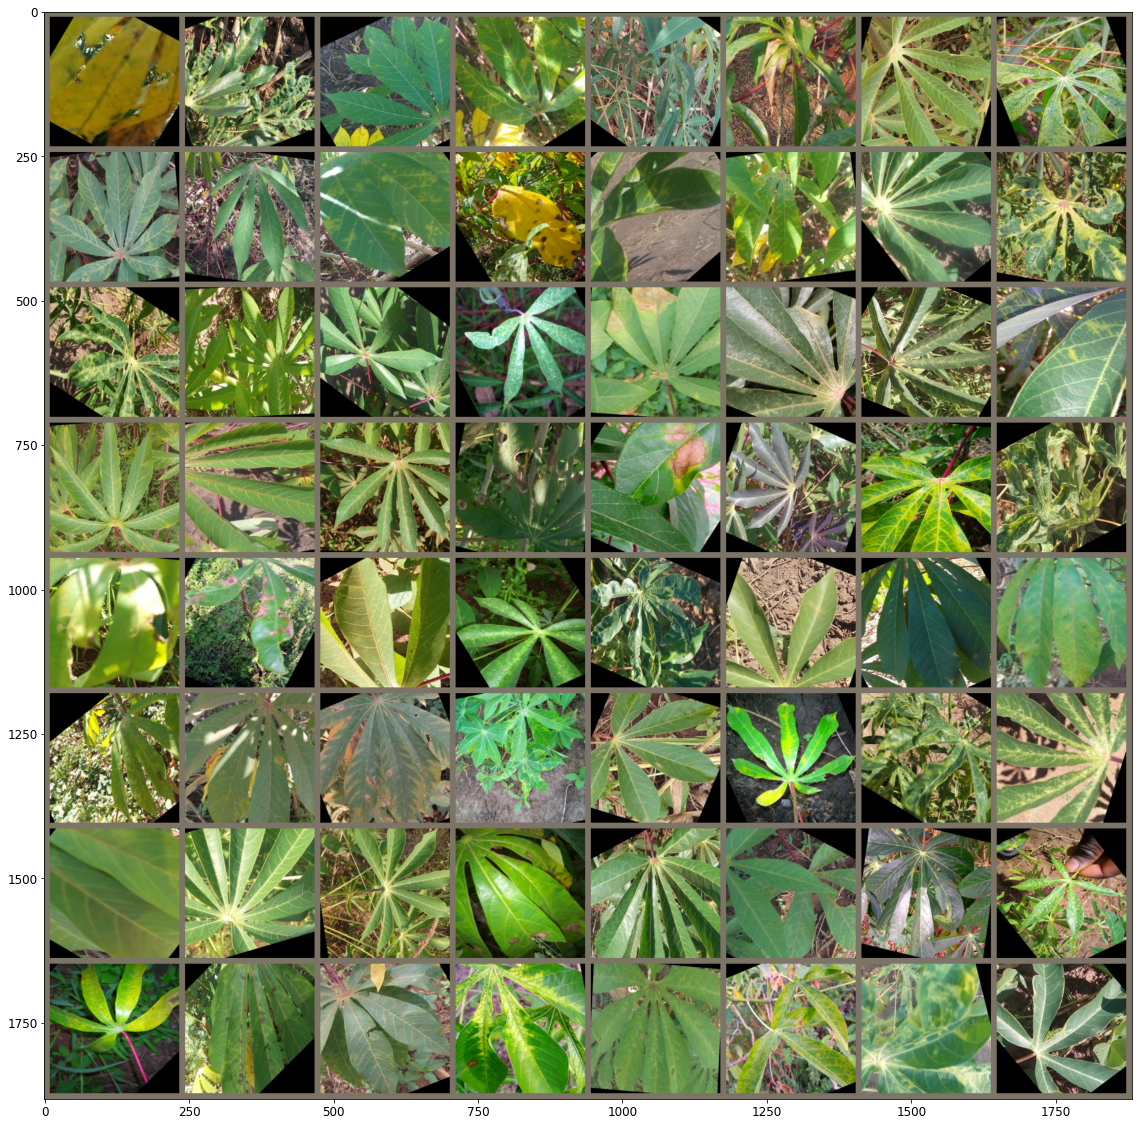

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # if title is not None:
    #     plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, padding=10)

plt.figure(figsize=(20,20))
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        epoch_start_time = time.time()

        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # Get model outputs and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # backward + optimize
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        time_elapsed = time.time() - epoch_start_time
        print('Train Loss: {:.4f} Acc: {:.4f} {:.0f}s'.format(epoch_loss, epoch_acc, time_elapsed)

        if epoch % 2 == 0:
            model.eval()   # Set model to evaluate mode
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # forward
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)


        time_elapsed = time.time() - epoch_start_time
        print('Train Loss: {:.4f} Acc: {:.4f} {:.0f}s'.format(epoch_loss, epoch_acc, time_elapsed)


                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val':
                    val_acc_history.append(epoch_acc)

        print('')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
%matplotlib inline

import math
def find_lr(model, loss_fn, optimizer, init_value=1e-8, final_value=10.0):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for inputs, labels in train_loader:
        batch_num += 1
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Crash out if loss explodes
        if batch_num > 1 and loss > 4 * best_loss:
            return log_lrs[10:-5], losses[10:-5]

        # Record the best loss
        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss)
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    return log_lrs[10:-5], losses[10:-5]

logs,losses = find_lr(model, criterion, optimizer)
plt.plot(logs,losses)
#found_lr = 1e-2